<a href="https://colab.research.google.com/github/cleodecker/tcc/blob/main/LCCNN_Hib_HMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar dados
# Carregar os dados
url = "https://raw.githubusercontent.com/cleodecker/tcc/main/df_all.csv"
cache_file = "df_all.csv"

if not os.path.exists(cache_file):
    df = pd.read_csv(url)
    df.to_csv(cache_file, index=False)
    print("Dataset baixado do GitHub e salvo em cache")
else:
    df = pd.read_csv(cache_file)
    print("Dataset carregado do cache local")
print(f'Dataset carregado: {df.shape}')
print(f'Colunas: {list(df.columns)}')
print(f'\nPrimeiras linhas:')
print(df.head())

# Renomear coluna de idade 0
df = df.rename(columns={'0': 'Age_0'})

# Verificar estrutura
print(f"Dimensões: {df.shape[0]} linhas, {df.shape[1]} colunas")
print(f"Países: {df['Country'].unique()}")
print(f"Anos: {df['Year'].min()} - {df['Year'].max()}")
print(f"Gênero: {df['Gender'].unique()}")  # Todos 0 (agregado)

# Dados faltantes?
print(f"Dados faltantes: {df.isnull().sum().sum()}")

# Organizar dados em formato longo
id_vars = ['Country', 'Year', 'Gender']
age_columns = ['Age_0', '1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90']

df_long = df.melt(
    id_vars=id_vars,
    value_vars=age_columns,
    var_name='Age',
    value_name='mx'
)

# Converter idade para numérico
df_long['Age'] = df_long['Age'].replace({'Age_0': 0}).astype(int)
df_long = df_long.sort_values(['Country', 'Year', 'Age'])

Dataset carregado do cache local
Dataset carregado: (7744, 23)
Colunas: ['Country', 'Year', '0', '1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', 'Gender']

Primeiras linhas:
   Country  Year        0        1        5       10       15       20  \
0        0  1950  0.02836  0.00182  0.00089  0.00076  0.00138  0.00206   
1        0  1951  0.02832  0.00189  0.00081  0.00077  0.00169  0.00223   
2        0  1952  0.02791  0.00171  0.00069  0.00064  0.00156  0.00203   
3        0  1953  0.02632  0.00170  0.00076  0.00069  0.00153  0.00189   
4        0  1954  0.02558  0.00176  0.00064  0.00062  0.00146  0.00183   

        25       30  ...       50       55       60       65       70  \
0  0.00164  0.00188  ...  0.01097  0.01736  0.02767  0.04246  0.06596   
1  0.00183  0.00193  ...  0.01125  0.01843  0.02888  0.04370  0.06585   
2  0.00185  0.00188  ...  0.01124  0.01791  0.02854  0.04394  0.06474   
3  0.00165  0.00177  ... 

In [10]:
# Separar homens e mulheres
df_long_m = df_long[df_long['Gender'] == 0]
df_long_f = df_long[df_long['Gender'] == 1]

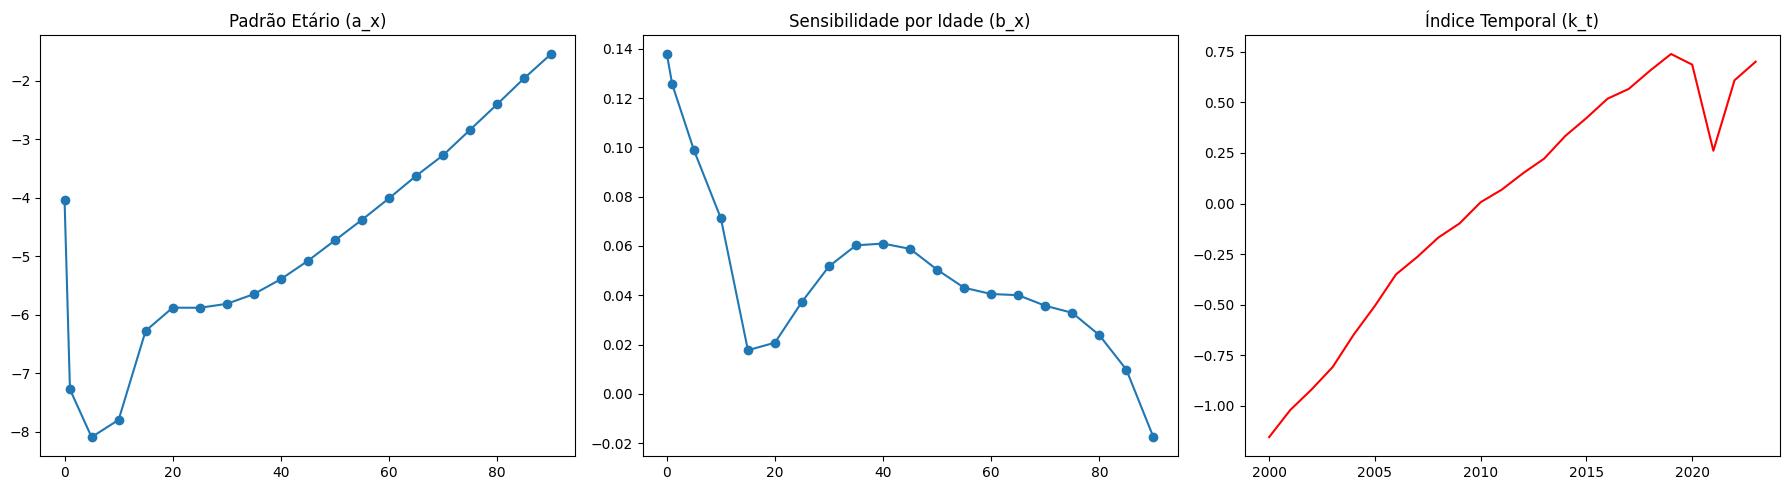

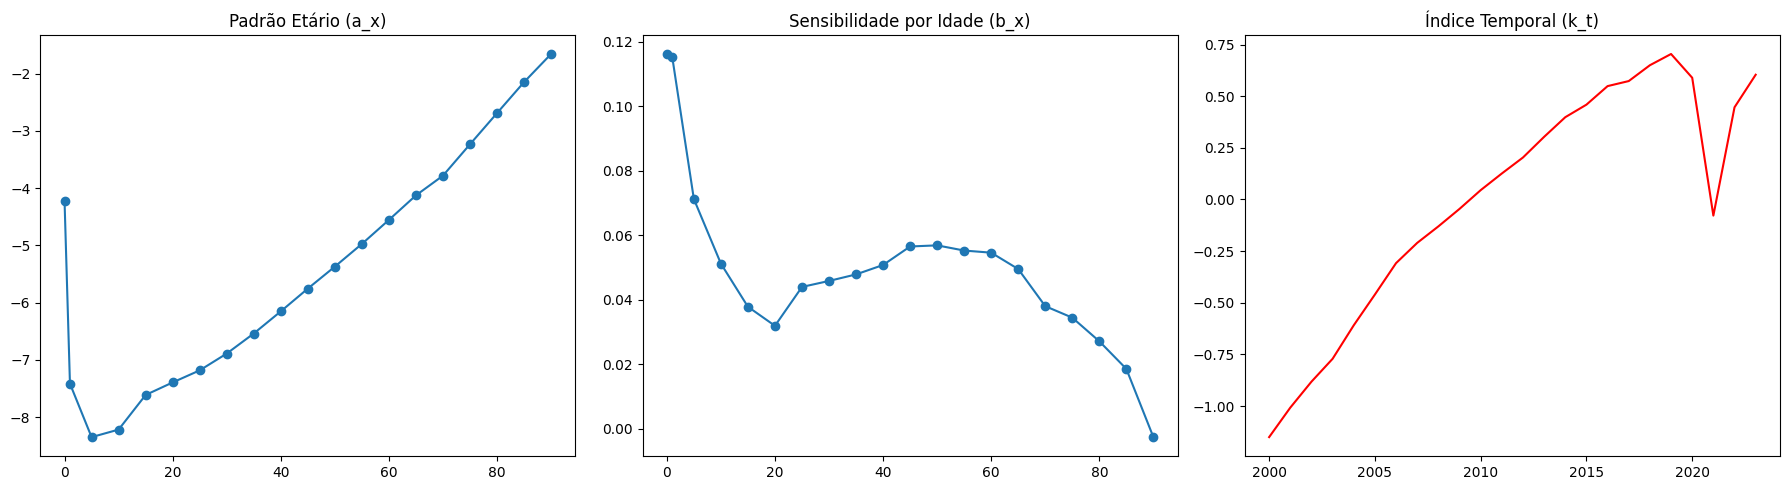

In [14]:
from numpy.linalg import svd

def fit_lee_carter(df_country):
    # Matriz log-mortalidade: years, gender x ages
    log_mx = df_country.pivot(index=['Year', 'Gender'], columns='Age', values='mx').apply(np.log)

    # Parâmetros do modelo
    a_x = log_mx.mean(axis=0)  # Média por idade
    Z = log_mx - a_x

    # SVD na matriz centralizada
    U, S, Vt = svd(Z, full_matrices=False)
    k_t = U[:, 0] * S[0]      # Primeiro componente temporal
    b_x = Vt[0, :]            # Primeiro componente etário

    # Normalização
    b_x = b_x / b_x.sum()
    k_t = k_t * b_x.sum()

    # The index of k_t is a MultiIndex (Year, Gender).
    # We need to handle this for plotting. Let's use the Year part of the index.
    years = log_mx.index.get_level_values('Year')
    ages = log_mx.columns


    return a_x, b_x, k_t, years, ages

# Aplicar ao Brasil (49) homens (0)
country_49_m = df_long_m[df_long_m['Country'] == 49]
a_x, b_x, k_t, years, ages = fit_lee_carter(country_49_m)

# Visualizar parâmetros
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.plot(a_x.index, a_x.values, 'o-')
ax1.set_title('Padrão Etário (a_x)')
ax2.plot(ages, b_x, 'o-')
ax2.set_title('Sensibilidade por Idade (b_x)')
ax3.plot(years, k_t, 'r-')
ax3.set_title('Índice Temporal (k_t)')
plt.tight_layout()
plt.show()

# Aplicar ao Brasil (49) mulheres (1)
country_49_f = df_long_f[df_long_f['Country'] == 49]
a_x_f, b_x_f, k_t_f, years_f, ages_f = fit_lee_carter(country_49_f)

# Visualizar parâmetros
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.plot(a_x_f.index, a_x_f.values, 'o-')
ax1.set_title('Padrão Etário (a_x)')
ax2.plot(ages_f, b_x_f, 'o-')
ax2.set_title('Sensibilidade por Idade (b_x)')
ax3.plot(years_f, k_t_f, 'r-')
ax3.set_title('Índice Temporal (k_t)')
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten

# Preparar dados para LCNN
def prepare_lcnn_data(k_t, window=10):
    X, y = [], []
    for i in range(len(k_t) - window):
        X.append(k_t[i:i+window])
        y.append(k_t[i+window])
    return np.array(X), np.array(y)

# Treinar modelo LSTM-CNN
def train_lcnn_model(X_train, y_train):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(
        X_train[..., np.newaxis], y_train,
        epochs=100, batch_size=16, verbose=0, validation_split=0.2
    )
    return model, history

# Aplicar ao índice k_t do País
window_size = 10
X, y = prepare_lcnn_data(k_t.values, window=window_size)
model, history = train_lcnn_model(X, y)

# Visualizar treinamento
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss do Modelo LCNN')
plt.legend()
plt.show()